In [1]:
import sklearn
sklearn.__version__

'0.22.1'

In [2]:
from itertools import product
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.datasets import load_iris
# For votingclassifier ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
# Support vector machine classifier - details in https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
from sklearn.svm import SVC
# StandardScaler for scaling the dataset
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)
from sklearn.tree import DecisionTreeClassifier

# 2. Ensemble Learning
----------------------
## a. VotingClassifier
----------------------
### VotingClassifier(estimators, *, voting='hard', weights=None, n_jobs=None, flatten_transform=True, verbose=False)
* #### Arguments: only "estimators" matters for now
 1.         estimators: list of (str, estimator) tuples - Invoking the fit method on the VotingClassifier will fit clones of those original estimators that will be stored in the class attribute self.estimators_. An estimator can be set to 'drop' using set_params.
  2.         voting : {‘hard’, ‘soft’}, default=’hard’- If ‘hard’, uses predicted class labels for majority rule voting. Else if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.
  3.       weights : array-like of shape (n_classifiers,), default=None - Sequence of weights (float or int) to weight the occurrences of predicted class labels (hard voting) or class probabilities before averaging (soft voting). Uses uniform weights if None.
  4.         n_jobs : int, default=None - The number of jobs to run in parallel for fit. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. 
  5.         flatten_transform : bool, default=True - Affects shape of transform output only when voting=’soft’ If voting=’soft’ and flatten_transform=True, transform method returns matrix with shape (n_samples, n_classifiers * n_classes). If flatten_transform=False, it returns (n_classifiers, n_samples, n_classes).
  6.         verbose : bool, default=False - If True, the time elapsed while fitting will be printed as it is completed.
* #### Artributes: (of the VotingClassifier object)
 *         estimators_ : list of classifiers - The collection of fitted sub-estimators as defined in estimators that are not ‘drop’.
 *         classes_ : array-like of shape (n_predictions,) - The classes labels.
* #### Methods: (on the VotingClassifier object)
 *         fit(self, X, y[, sample_weight]) : Fit the estimators.
 *         fit_transform(self, X[, y]) : Fit to data, then transform it.
 *         get_params(self[, deep]) : Get the parameters of an estimator from the ensemble.
 *         predict(self, X) : Predict class labels for X.
 *         score(self, X, y[, sample_weight]) : Return the mean accuracy on the given test data and labels.
 *         set_params(self, \*\*params) : Set the parameters of an estimator from the ensemble.
 *         transform(self, X) : Return class labels or probabilities for X for each estimator.

In [3]:
#read in the dataset
df = pd.read_csv('dataset/datasets_diabetes.csv')
#take a look at the data
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# X : dataset feature, y : dataset label
X = df.drop(columns = ['Outcome'])
y = df['Outcome']
# normalize dataset for training
X = StandardScaler().fit_transform(X)
#split data into train and test sets - Ratio : 4:1 (4 for training, 1 for test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [5]:
# Exercises
# EX 3.a.1: Create three models

#create new a knn model
### YOUR CODE HERE (Fill in the "None")
# Hint: knn is a default KNeighborsClassifier object. 
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
#fit model to training data
knn_gs.fit(X_train, y_train)

#create a new logistic regression model
# Hint: log_reg is a default LogisticRegression object.
log_reg = LogisticRegression()
#fit the model to the training data
log_reg.fit(X_train, y_train)

# create new support vector machine classifier
# Hint: svc is a SVC object which enable probability estimates. 
# Hint: It can be handled by 'probability' parameter whose value is boolean.
# Important : Use probabilistic Support Vector Machine Classifier, 
# which outputs class probability(For soft ensemble, as we will describe later)
svc = SVC(probability=True)
#fit the model to the training data
svc.fit(X_train, y_train)

# Check the accuracy score of all 3 model. for diabete prediction
print('knn: {}'.format(knn_gs.score(X_test, y_test)))
print('svc: {}'.format(svc.score(X_test, y_test)))
print('log_reg: {}'.format(log_reg.score(X_test, y_test)))

knn: 0.7532467532467533
svc: 0.7467532467532467
log_reg: 0.7532467532467533


In [6]:
# Ex 3.a.2: Create weighted majority ensemble model

# create a 'estimators' for VotingClassifier parameter - Hard voting(Majority rule)
# Hint: Parameter 'estimators' of VotingClassifier : list of (str, estimator) tuples
estimators=[('knn', knn_gs), ('svc', svc), ('log_reg', log_reg)]
# create VotingClassifier estimator - Weighted majority ensemble model
# Hint: If the parameter 'voting' is `hard', uses predicted class labels for majority rule voting. 
# Hint: Else if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.
ensemble_hard = VotingClassifier(estimators, voting='hard')
# Train weight of VotingClassifier object for ensemble using training dataset
ensemble_hard.fit(X_train, y_train)
# score the result of ensemble model on test dataset
ensemble_hard.score(X_test, y_test)

0.7532467532467533

In [7]:
# Ex 3.a.3: Create soft voting model

# create a VotingClassifier estimator - Soft voting(Average class probability)
# Hint: If the parameter 'voting' is `hard', uses predicted class labels for majority rule voting. 
# Hint: Else if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.
ensemble_soft = VotingClassifier(estimators, voting='soft')
ensemble_soft.fit(X_train, y_train)
ensemble_soft.score(X_test, y_test)

0.7467532467532467

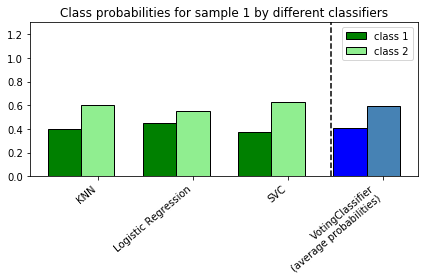

In [8]:
# plotting
# obtain class probabilities for all 4 models - KNN, Logistic Regression, SVC, ensemble
probas = [c.predict_proba(X_test) for c in (knn_gs, log_reg, svc, ensemble_soft)]
# get class probabilities for the first sample in the dataset
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]

N = 4  # number of groups
ind = np.arange(N)  # group positions
width = 0.35  # bar width

fig, ax = plt.subplots()

# bars for classifier 1-3
p1 = ax.bar(ind, np.hstack(([class1_1[:-1], [0]])), width,
            color='green', edgecolor='k')
p2 = ax.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), width,
            color='lightgreen', edgecolor='k')

# bars for VotingClassifier
p3 = ax.bar(ind, [0, 0, 0, class1_1[-1]], width,
            color='blue', edgecolor='k')
p4 = ax.bar(ind + width, [0, 0, 0, class2_1[-1]], width,
            color='steelblue', edgecolor='k')

# plot annotations
plt.axvline(2.8, color='k', linestyle='dashed')
ax.set_xticks(ind + width)
ax.set_xticklabels(['KNN',
                    'Logistic Regression',
                    'SVC',
                    'VotingClassifier\n(average probabilities)'],
                   rotation=40,
                   ha='right')
plt.ylim([0, 1.3])
plt.title('Class probabilities for sample 1 by different classifiers')
plt.legend([p1[0], p2[0]], ['class 1', 'class 2'], loc='upper right')
plt.tight_layout()
plt.show()

# 2. Ensemble Learning
----------------------
## b. AdaBoostClassifier (Boosting)
----------------------
* An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases
### AdaBoostClassifier(base_estimator=None, *, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)
 #### Arguments: only "n_estimators" matters for now
 1.         base_estimator : object, default=None - The base estimator from which the boosted ensemble is built. Support for sample weighting is required, as well as proper classes_ and n_classes_ attributes. If None, then the base estimator is DecisionTreeClassifier(max_depth=1).
  2.        n_estimators : int, default=50 - The maximum number of estimators at which boosting is terminated. In case of perfect fit, the learning procedure is stopped early.
  3.        learning_rate : float, default=1 - Learning rate shrinks the contribution of each classifier by learning_rate. There is a trade-off between learning_rate and n_estimators.
  4.        algorithm : {‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’- If ‘SAMME.R’ then use the SAMME.R real boosting algorithm. base_estimator must support calculation of class probabilities. If ‘SAMME’ then use the SAMME discrete boosting algorithm. The SAMME.R algorithm typically converges faster than SAMME, achieving a lower test error with fewer boosting iterations.
  5.        random_state : int or RandomState, default=None - Controls the random seed given at each base_estimator at each boosting iteration. Thus, it is only used when base_estimator exposes a random_state. Pass an int for reproducible output across multiple function calls.
  6.         verbose : bool, default=False - If True, the time elapsed while fitting will be printed as it is completed.
  
 #### Artributes: (of the VotingClassifier object)
 *         base_estimator_ : estimator - The base estimator from which the ensemble is grown.
 *         estimators_ : list of classifiers - The collection of fitted sub-estimators as defined in estimators that are not ‘drop’.
 *         classes_ : ndarray of shape (n_classes,) - The classes labels.
 *         n_classes_ : int - The number of classes.
 *         estimator_weights_ : ndarray of floats - Weights for each estimator in the boosted ensemble.
 *         estimator_errors_ : ndarray of floats - Classification error for each estimator in the boosted ensemble.
 *         feature_importances_ : ndarray of shape (n_features,) - The impurity-based feature importances.
 
  #### Methods: (on the VotingClassifier object)
 * decision_function(self, X) : Compute the decision function of X.
 * fit(self, X, y[, sample_weight]) : Build a boosted classifier from the training set (X, y).
 * get_params(self[, deep]) : Get parameters for this estimator.
 * predict(self, X) :  Predict classes for X.
 * predict_log_proba(self, X) : Predict class log-probabilities for X.
 * predict_proba(self, X) : Predict class probabilities for X.
 * score(self, X, y[, sample_weight]) : Return the mean accuracy on the given test data and labels.
 * set_params(self, \*\*params) : Set the parameters of this estimator.
 * staged_decision_function(self, X) : Compute decision function of X for each boosting iteration.
 * staged_predict(self, X) : Return staged predictions for X.
 * staged_predict_proba(self, X) : Predict class probabilities for X.
 * staged_score(self, X, y[, sample_weight]) : Return staged scores for X, y.

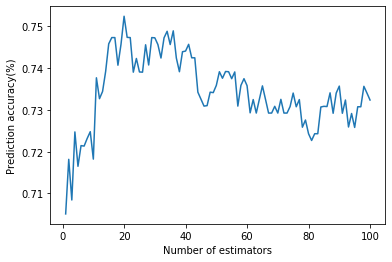

In [9]:
# Ex. 3.b.1: AdaBoostClassifier

# Set up the estimator range
estimator = list(range(1,101))
# To find best number of estimator, initialize best_estimator and max_score, and best_model
best_estimator = -1
max_score = -1
best_model = None
# To plot the trend of score along the estomator, initialize the list of score
score_list = []
for n_estimators in estimator :
    # Create AdaBoostClassifier with n_estimators.
    # Hint: The number of estimators are configured by 'n_estimators' parameter.
    # Hint: We use 0 as seed which is given at each base_estimator at each boosting iteration.
    AdaBoost_clf = AdaBoostClassifier(n_estimators=n_estimators, random_state=0)
    k_folds = KFold(n_splits=20)
    results = cross_val_score(AdaBoost_clf, X_train, y_train, cv=k_folds)
    score = results.mean()
    score_list.append(score)
    if score > max_score :
        max_score = score
        best_estimator = n_estimators
        best_model = AdaBoost_clf
plt.plot(estimator, score_list)
plt.xlabel('Number of estimators')
plt.ylabel('Prediction accuracy(%)')
plt.show()

In [10]:
# print the best estimator number and the maximum score
print("Best Estimator number : {} / Best prediction accuracy : {}".format(best_estimator, max_score))

Best Estimator number : 20 / Best prediction accuracy : 0.7524193548387097


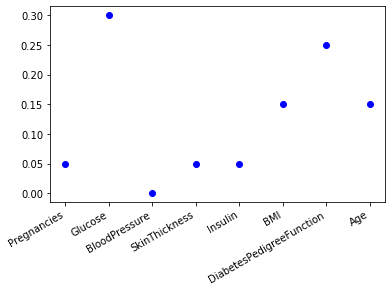

In [11]:
# Ex. 3.b.2: plot feature importances

# Create AdaBoostClassifier
# Hint: the number of estimators giving the best performance is best_estimator.
AdaBoost_clf = AdaBoostClassifier(n_estimators=best_estimator, random_state=0)
AdaBoost_clf.fit(X_train, y_train)
fig, ax = plt.subplots()
x=list(df.columns[:-1])

# Plot AdaBoost classifier's feature importances
ax.plot_date(x, AdaBoost_clf.feature_importances_, 'bo')
fig.autofmt_xdate()
plt.show()

# 2. Ensemble Learning
----------------------
## c. BaggingClassifier (Bagging)
----------------------
* A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregates their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.
### BaggingClassifier(base_estimator=None, n_estimators=10, *, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0)
 #### Arguments: only "n_estimators" matters for now
 1.         base_estimator : object, default=None - The base estimator from which the boosted ensemble is built. Support for sample weighting is required, as well as proper classes_ and n_classes_ attributes. If None, then the base estimator is DecisionTreeClassifier(max_depth=1).
  2.        n_estimators : int, default= 10 - The number of base estimators in the ensemble.
  3.        max_features : int or float, default=1.0 - The number of features to draw from X to train each base estimator (without replacement by default)
  4.        bootstrap : bool, default=True -  Whether samples are drawn with replacement. If False, sampling without replacement is performed.
  5.        bootstrap_features : bool, default=False - Whether features are drawn with replacement.
  6.        oob_score : bool, default=False - Whether to use out-of-bag samples to estimate the generalization error.
  7.         warm_start : bool, default=False - When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new ensemble.
  8.         n_jobs : int, default=None -  The number of jobs to run in parallel for both fit and predict. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.
  9.         random_state : int or RandomState, default=None - Controls the random resampling of the original dataset (sample wise and feature wise). If the base estimator accepts a random_state attribute, a different seed is generated for each instance in the ensemble. Pass an int for reproducible output across multiple function calls.
  10.        verbose : bool, default=False - Controls the verbosity when fitting and predicting.
  
 #### Artributes: (of the VotingClassifier object)
 *         base_estimator_ : estimator - The base estimator from which the ensemble is grown.
 *         estimators_ : list of classifiers - The collection of fitted sub-estimators as defined in estimators that are not ‘drop’.
 *         estimators_samples_ : list of arrays - The subset of drawn samples for each base estimator.
 *         estimators_features_ : list of arrays - The subset of drawn features for each base estimator.
 *         classes_ : ndarray of shape (n_classes,) - The classes labels.
 *         n_classes_ : int - The number of classes.
 *         oob_score_ : float - Score of the training dataset obtained using an out-of-bag estimate. This attribute exists only when oob_score is True.
 *         oob_decision_function_ : ndarray of shape (n_samples, n_classes) - Decision function computed with out-of-bag estimate on the training set. If n_estimators is small it might be possible that a data point was never left out during the bootstrap. In this case, oob_decision_function_ might contain NaN. This attribute exists only when oob_score is True.
  #### Methods: (on the VotingClassifier object)
 * decision_function(self, X) : Compute the decision function of X.
 * fit(self, X, y[, sample_weight]) : Build a boosted classifier from the training set (X, y).
 * get_params(self[, deep]) : Get parameters for this estimator.
 * predict(self, X) :  Predict classes for X.
 * predict_log_proba(self, X) : Predict class log-probabilities for X.
 * predict_proba(self, X) : Predict class probabilities for X.
 * score(self, X, y[, sample_weight]) : Return the mean accuracy on the given test data and labels.
 * set_params(self, \*\*params) : Set the parameters of this estimator.

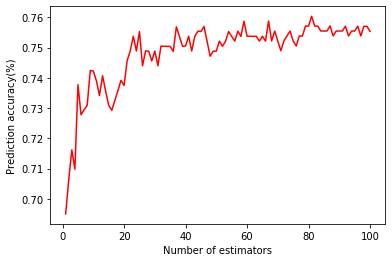

In [12]:
# Ex. 3.c.1: BaggingClassifier

# Set up the estimator range
estimator = list(range(1,101))
# To find best number of estimator, initialize best_estimator and max_score, and best_model
best_estimator = -1
max_score = -1
best_model = None
# To plot the trend of score along the estomator, initialize the list of score
score_list = []
for n_estimators in estimator :
    # Create BaggingClassifier instance.
    # Hint: The number of estimators are configured by 'n_estimators' parameter.
    Bagging_clf = BaggingClassifier(n_estimators=n_estimators, random_state=0)
    k_folds = KFold(n_splits=20)
    results = cross_val_score(Bagging_clf, X_train, y_train, cv=k_folds)
    score = results.mean()
    score_list.append(score)
    if score > max_score :
        max_score = score
        best_estimator = n_estimators
        best_model = Bagging_clf
plt.plot(estimator, score_list, 'r')
plt.xlabel('Number of estimators')
plt.ylabel('Prediction accuracy(%)')
plt.show()

In [13]:
# print the best estimator number and the maximum score
print("Best Estimator number : {} / Best prediction accuracy : {}".format(best_estimator, max_score))

Best Estimator number : 81 / Best prediction accuracy : 0.7603763440860215


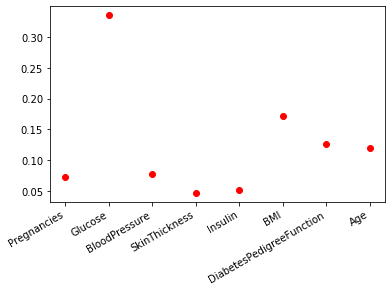

In [14]:
# Ex. 3.c.2: plot feature importances

best_model.fit(X_train, y_train)
# 
# Hint: Find the feature importance of BaggingClassifier by averaging feature importance of base estimators (Use attribute 'estimators_')
feature_importances = np.mean([
    tree.feature_importances_ for tree in best_model.estimators_
], axis=0)
fig, ax = plt.subplots()
x=list(df.columns[:-1])
ax.plot_date(x, feature_importances, 'ro')
fig.autofmt_xdate()
plt.show()

# 2. Ensemble Learning
----------------------
## d. RandomForestClassifier
----------------------
* A random forest classifier. A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.
### RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 
 #### Arguments: only "n_estimators" matters for now
  1.        n_estimators : int, default= 10 - The number of base estimators in the ensemble.
  2.        criterion : {“gini”, “entropy”}, default=”gini”- The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific.
  3.        max_depth : int, default=None - The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
  4.        min_samples_split : int or float, default=2 - The minimum number of samples required to split an internal node: If int, then consider min_samples_split as the minimum number. If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.
  5.        min_samples_leaf : int or float, default=1 - The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression. If int, then consider min_samples_leaf as the minimum number. If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.
  6.        min_weight_fraction_leaf : float, default=0.0 - The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.
  7.        max_features : {“auto”, “sqrt”, “log2”}, int or float, default=”auto”- The number of features to consider when looking for the best split:
    * If int, then consider max_features features at each split.
    * If float, then max_features is a fraction and int(max_features * n_features) features are considered at each split.
    * If “auto”, then max_features=sqrt(n_features).
    * If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
    * If “log2”, then max_features=log2(n_features).
    * If None, then max_features=n_features.
  
 #### Artributes: (of the VotingClassifier object)
 *         base_estimator_ : The child estimator template used to create the collection of fitted sub-estimators.
 *         estimators_ : list of DecisionTreeClassifier - The collection of fitted sub-estimators.
 *         classes_ : ndarray of shape (n_classes,) - The classes labels.
 *         n_classes_ : int - The number of classes.
 *         n_features_ : int - The number of features when fit is performed.
 *         n_outputs_int : The number of outputs when fit is performed.
 *         feature_importances_ : ndarray of shape (n_features,) - The impurity-based feature importances.
 * oob_score_ : float - Score of the training dataset obtained using an out-of-bag estimate. This attribute exists only when oob_score is True.
 * oob_decision_function_ : ndarray of shape (n_samples, n_classes) - Decision function computed with out-of-bag estimate on the training set. If n_estimators is small it might be possible that a data point was never left out during the bootstrap. In this case, oob_decision_function_ might contain NaN. This attribute exists only when oob_score is True.

 #### Methods: (on the VotingClassifier object)
 * apply(self, X) : Apply trees in the forest to X, return leaf indices.
 * decision_path(self, X) : Return the decision path in the forest.
 * fit(self, X, y[, sample_weight]) : Build a forest of trees from the training set (X, y).
 * get_params(self[, deep]) : Get parameters for this estimator.
 * predict(self, X) :  Predict classes for X.
 * predict_log_proba(self, X) : Predict class log-probabilities for X.
 * predict_proba(self, X) : Predict class probabilities for X.
 * score(self, X, y[, sample_weight]) : Return the mean accuracy on the given test data and labels.
 * set_params(self, \*\*params) : Set the parameters of this estimator.

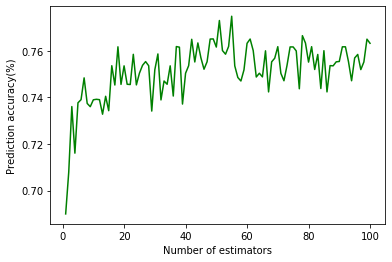

In [15]:
# Ex. 3.d.1: RandomForestClassifier

# Set up the estimator range
estimator = list(range(1,101))
# To find best number of estimator, initialize best_estimator and max_score, and best_model
best_estimator = -1
max_score = -1
best_model = None
# To plot the trend of score along the estomator, initialize the list of score
score_list = []
for n_estimators in estimator :
    # Create RandomForestClassifier instance.
    # Hint: The number of estimators are configured by 'n_estimators' parameter.
    # Hint: Set base estimators(Decision Tree) to use 'entropy' as criterion.
    RandomF_clf = RandomForestClassifier(n_estimators=n_estimators, criterion='entropy')
    k_folds = KFold(n_splits=20)
    results = cross_val_score(RandomF_clf, X_train, y_train, cv=k_folds)
    score = results.mean()
    score_list.append(score)
    if score > max_score :
        max_score = score
        best_estimator = n_estimators
        best_model = RandomF_clf
plt.plot(estimator, score_list, 'g')
plt.xlabel('Number of estimators')
plt.ylabel('Prediction accuracy(%)')
plt.show()

In [16]:
# print the best estimator number and the maximum score
print("Best Estimator number : {} / Best prediction accuracy : {}".format(best_estimator, max_score))

Best Estimator number : 55 / Best prediction accuracy : 0.7748387096774192


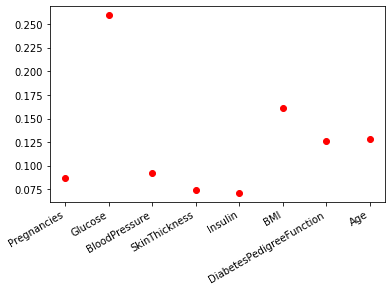

In [17]:
# Ex. 3.d.2: plot feature importance

best_model.fit(X_train, y_train)
feature_importances = best_model.feature_importances_
fig, ax = plt.subplots()
x=list(df.columns[:-1])
ax.plot_date(x, feature_importances, 'ro')
fig.autofmt_xdate()
plt.show()

## Reference
1. https://scikit-learn.org/stable/modules/ensemble.html
2. https://towardsdatascience.com/ensemble-learning-using-scikit-learn-85c4531ff86a  
3. https://stackabuse.com/ensemble-voting-classification-in-python-with-scikit-learn/ 
4. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
5. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
6. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
7. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html